In [1]:
import random
import bisect
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import pearsonr
import scipy
import json
import os
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
class Metadata:
    def __init__(self, ids, cels, metadata):
        self.IDs = ids
        self.CELs = cels
        self.modal_allele = [int(metadata[i]["modal_allele"]) for i in ids]
        self.progenitor_allele = [int(metadata[i]["progenitor_allele"]) for i in ids]
        self.MIRS = [int(metadata[i]["MIRS"]) for i in ids]
    def __str__(self):
        return "Metadata={{IDs: {}...,\n CELs: {}...,\n modal_allele: {}...,\n progenitor_allele: {}...,\n MIRS: {}...}}".format(self.IDs[:5], self.CELs[:5], self.modal_allele[:5], self.progenitor_allele[:5], self.MIRS[:5])
    def __repr__(self):
        return self.__str__()

def load_metadata():
    metadata = {}
    metadata_order = []
    with open("metadata.txt") as f:
        for i, line in enumerate(f):
            line = line.strip().split()
            if i == 0:
                names = line[1:]
            else:
                values = line[1:]
                patient_id = line[0]
                metadata_order.append(patient_id)
                metadata[patient_id] = {k: v for k, v in zip(names, values)}
    blood_IDs = [i for i in metadata_order]
    muscle_IDs = [i for i in metadata_order if metadata[i]["muscle_cel"] != "refused_biopsy"]
    blood_CELs = [metadata[i]["blood_cel"] for i in blood_IDs]
    muscle_CELs = [metadata[i]["muscle_cel"] for i in muscle_IDs]
        
    blood_record = Metadata(blood_IDs, blood_CELs, metadata)
    muscle_record = Metadata(muscle_IDs, muscle_CELs, metadata)
    return blood_record, muscle_record

blood_meta, muscle_meta = load_metadata()

def simulated_r2(metadata, times):
    r2s = []
    for i in range(times):
        repeat_length_random = metadata.modal_allele[:]
        random.shuffle(repeat_length_random)
        inter_r, _ = pearsonr(metadata.modal_allele, repeat_length_random)
        r2s.append(inter_r**2)
    r2s.sort()
    def check_value(r_squared):
        p_value = 1 - bisect.bisect_right(r2s, r_squared)/float(times)
        return p_value
    return check_value

In [3]:
r2_simulation_size = 10**6

In [4]:
muscle_r2_to_p = simulated_r2(muscle_meta, r2_simulation_size)

In [5]:
blood_r2_to_p = simulated_r2(blood_meta, r2_simulation_size)

In [6]:
import bootstrapped
import numpy
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import scipy.stats as st

In [7]:
import numpy as np
def present_result(name, tissue, real_allele, simulated_allele, r_squared, p_value, rmse, repeats, title = True):
    plt.figure(figsize=(30, 20))
    x = real_allele
    y = simulated_allele
    plt.scatter([i + np.random.normal(0, 5) for i in x], y, alpha=0.1, marker=",")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), linewidth=4, color="r")
    plt.xlabel("Measured allele length", fontsize=50)
    plt.ylabel("Predicted allele length", fontsize=50)
    if title:
        plt.title("{} predictions of MAL using {} dataset in {}. r² is {} corresponding p-value {}".format(repeats, name, tissue, r_squared, p_value))
    print("Repeating the experiment {} times, In {}, {} r² is {}, RMSE is {}, which corresponds to p-value {}".format(repeats, name, tissue, r_squared, rmse, p_value))

In [8]:
r2_to_p = {"muscle": muscle_r2_to_p, "blood": blood_r2_to_p}

In [19]:
import sklearn.metrics

In [9]:
def present_results_path(path, title = True):
    with open(path) as f:
        data = json.load(f)
        predicted_alleles, real_alleles = data["predicted_alleles"], data["real_alleles"]
        r, _ = pearsonr(real_alleles, predicted_alleles)
        rmse = sqrt(mean_squared_error(real_alleles, predicted_alleles))
        r_square = r**2
        filename = path.split("/")[-1]
        name, tissue, simulation_repeat, probes, dimensions = filename.split("_")[:5]
        present_result(name, tissue, real_alleles, predicted_alleles, r_square, r2_to_p[tissue](r_square), rmse, simulation_repeat, title=title)

In [24]:
def present_results_r2(path):
    with open(path) as f:
        data = json.load(f)
        predicted_alleles, real_alleles = data["predicted_alleles"], data["real_alleles"]
        r, _ = pearsonr(real_alleles, predicted_alleles)
        rmse = sqrt(mean_squared_error(real_alleles, predicted_alleles))
        r_square = r**2
        r2_sklearn = sklearn.metrics.r2_score(real_alleles, predicted_alleles)
        print(r_square, rmse, r2_sklearn)

In [11]:
def aggregate_experiments(paths):
    prefix = "simulation_results"
    final_result = {"predicted_alleles" : [], "real_alleles": []}
    aggregate_size = 0
    for filename in paths:
        current_size = int(filename.split("_")[2])
        aggregate_size += current_size
        with open(os.path.join(prefix, filename)) as f:
            result = json.load(f)
            for key in result:
                final_result[key].extend(result[key])
    horrible_filepath = os.path.join(prefix, "_".join(["_".join(paths[0].split("_")[:2]), str(aggregate_size), "_".join(paths[0].split("_")[3:])]))
    print(horrible_filepath)
    with open(horrible_filepath, "w") as f:
        json.dump(final_result, f)

# Results with PLSR 

In [13]:
paths_to_aggregate = [["TNNI1_muscle_995_500_simulation_step_PLSR", "TNNI1_muscle_996_500_simulation_step_PLSR", "TNNI1_muscle_997_500_simulation_step_PLSR", "TNNI1_muscle_998_500_simulation_step_PLSR", "TNNI1_muscle_999_500_simulation_step_PLSR", "TNNI1_muscle_1001_500_simulation_step_PLSR", "TNNI1_muscle_1002_500_simulation_step_PLSR", "TNNI1_muscle_1003_500_simulation_step_PLSR", "TNNI1_muscle_1004_500_simulation_step_PLSR", "TNNI1_muscle_1005_500_simulation_step_PLSR"],
                      ["TNNI1_blood_10000_500_simulation_step_PLSR"],
                      ["nakamori_muscle_3330_500_simulation_step_PLSR", "nakamori_muscle_3334_500_simulation_step_PLSR", "nakamori_muscle_3336_500_simulation_step_PLSR"],
                      #["nakamori_muscle_3330_500_simulation_step_LinearRegression", "nakamori_muscle_3334_500_simulation_step_LinearRegression", "nakamori_muscle_3336_500_simulation_step_LinearRegression"],
                      #["nakamori_muscle_3330_500_simulation_step_RandomForestRegressor", "nakamori_muscle_3334_500_simulation_step_RandomForestRegressor", "nakamori_muscle_3336_500_simulation_step_RandomForestRegressor"],
                      #["nakamori_muscle_3334_500_simulation_step_LASSO", "nakamori_muscle_3336_500_simulation_step_LASSO", "nakamori_muscle_3330_500_simulation_step_LASSO"],
                      ["batra_blood_3330_500_simulation_step_PLSR", "batra_blood_3334_500_simulation_step_PLSR", "batra_blood_3336_500_simulation_step_PLSR"],
                      ["batra_muscle_3330_500_simulation_step_PLSR", "batra_muscle_3334_500_simulation_step_PLSR", "batra_muscle_3336_500_simulation_step_PLSR"],
                      ["nakamori_blood_3330_500_simulation_step_PLSR", "nakamori_blood_3334_500_simulation_step_PLSR", "nakamori_blood_3336_500_simulation_step_PLSR"],
                      ["all_muscle_995_500_simulation_step_PLSR", "all_muscle_996_500_simulation_step_PLSR", "all_muscle_997_500_simulation_step_PLSR", "all_muscle_998_500_simulation_step_PLSR", "all_muscle_999_500_simulation_step_PLSR", "all_muscle_1001_500_simulation_step_PLSR", "all_muscle_1002_500_simulation_step_PLSR", "all_muscle_1003_500_simulation_step_PLSR", "all_muscle_1004_500_simulation_step_PLSR", "all_muscle_1005_500_simulation_step_PLSR"],
                      ["all_blood_995_500_simulation_step_PLSR", "all_blood_996_500_simulation_step_PLSR", "all_blood_997_500_simulation_step_PLSR", "all_blood_998_500_simulation_step_PLSR", "all_blood_999_500_simulation_step_PLSR", "all_blood_1001_500_simulation_step_PLSR", "all_blood_1002_500_simulation_step_PLSR", "all_blood_1003_500_simulation_step_PLSR", "all_blood_1004_500_simulation_step_PLSR", "all_blood_1005_500_simulation_step_PLSR"]
                     ]

for path in paths_to_aggregate:
    aggregate_experiments(path)

simulation_results/TNNI1_muscle_10000_500_simulation_step_PLSR
simulation_results/TNNI1_blood_10000_500_simulation_step_PLSR
simulation_results/nakamori_muscle_10000_500_simulation_step_PLSR
simulation_results/batra_blood_10000_500_simulation_step_PLSR
simulation_results/batra_muscle_10000_500_simulation_step_PLSR
simulation_results/nakamori_blood_10000_500_simulation_step_PLSR
simulation_results/all_muscle_10000_500_simulation_step_PLSR
simulation_results/all_blood_10000_500_simulation_step_PLSR


In [15]:
font = {'family' : 'DejaVu Sans',
        'size'   : 25}

matplotlib.rc('font', **font)

Repeating the experiment 10000 times, In TNNI1, muscle r² is 0.3220035503052671, RMSE is 326.26581205606396, which corresponds to p-value 0.0023480000000000167


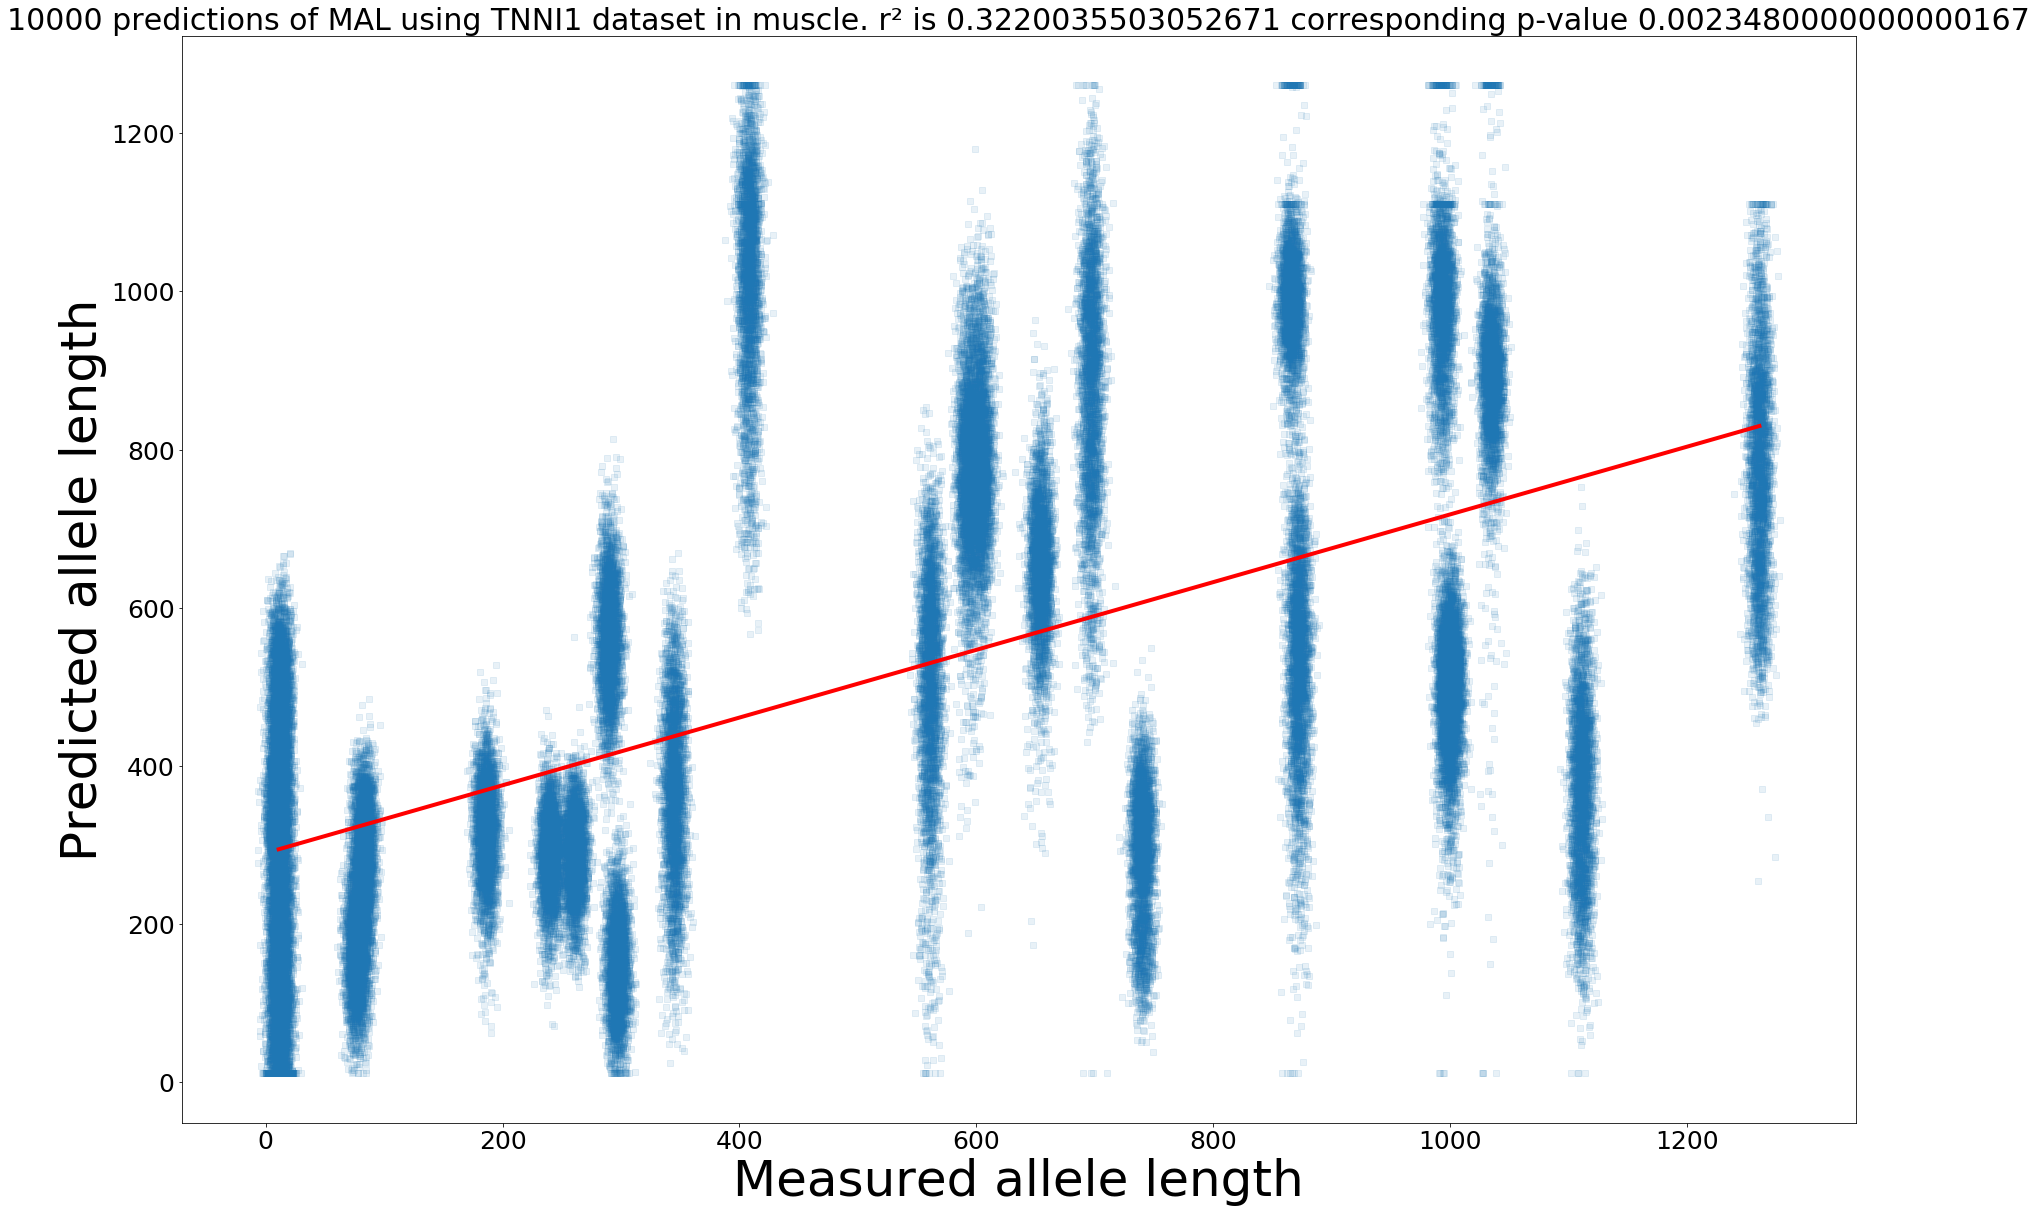

In [16]:
present_results_path("simulation_results/TNNI1_muscle_10000_500_simulation_step_PLSR")

In [28]:
PLSR_blood_paths = ["simulation_results/nakamori_blood_10000_500_simulation_step_PLSR",
                    "simulation_results/batra_blood_10000_500_simulation_step_PLSR",
                    "simulation_results/TNNI1_blood_10000_500_simulation_step_PLSR",
                    "simulation_results/all_blood_10000_500_simulation_step_PLSR"]

PLSR_muscle_paths = ["simulation_results/nakamori_muscle_10000_500_simulation_step_PLSR",
                     "simulation_results/batra_muscle_10000_500_simulation_step_PLSR",
                     "simulation_results/TNNI1_muscle_10000_500_simulation_step_PLSR",
                     "simulation_results/all_muscle_10000_500_simulation_step_PLSR"]

In [60]:
def print_table(paths, tissue):
    r2_results = []
    rmse_results = []
    pvalue_results = []
    for path in paths:
        with open(path) as f:
            data = json.load(f)
        predicted_alleles, real_alleles = data["predicted_alleles"], data["real_alleles"]
        
        r, _ = pearsonr(real_alleles, predicted_alleles)
        rmse = sqrt(mean_squared_error(real_alleles, predicted_alleles))
        r_square = r**2
        
        r2_results.append(round(r_square, 3))
        rmse_results.append(round(rmse, 3))
        pvalue_results.append(round(r2_to_p[tissue](r_square), 4))

    header = "& DM1-AS & DM1-APA & TNNI1 & ALL \\\\ \hline"
    r2 = "R\\textsuperscript{2}" + " & {} & {} & {} & {} \\\\ \hline".format(*r2_results)
    pvalue = "p-value & {} & {} & {} & {} \\\\ \hline".format(*pvalue_results)
    rmse_results = "RMSE & {} & {} & {} & {} \\\\ \hline".format(*rmse_results)
    
    print(header)
    print(r2)
    print(pvalue)
    print(rmse_results)

In [61]:
print_table(PLSR_muscle_paths, "muscle")

& DM1-AS & DM1-APA & TNNI1 & ALL \\ \hline
R\textsuperscript{2} & 0.285 & 0.151 & 0.322 & 0.085 \\ \hline
p-value & 0.0046 & 0.0455 & 0.0023 & 0.1396 \\ \hline
RMSE & 327.821 & 361.443 & 326.266 & 370.429 \\ \hline


In [63]:
print_table(PLSR_blood_paths, "blood")

& DM1-AS & DM1-APA & TNNI1 & ALL \\ \hline
R\textsuperscript{2} & 0.044 & 0.104 & 0.049 & 0.011 \\ \hline
p-value & 0.2239 & 0.0586 & 0.2014 & 0.5506 \\ \hline
RMSE & 363.334 & 344.767 & 392.414 & 371.649 \\ \hline


In [27]:
round(123.1279812, 3)

123.128

Repeating the experiment 10000 times, In TNNI1, muscle r² is 0.3220035503052671, RMSE is 326.26581205606396, which corresponds to p-value 0.0023480000000000167
Repeating the experiment 10000 times, In TNNI1, blood r² is 0.04881863722596528, RMSE is 392.4138111179477, which corresponds to p-value 0.20140499999999995
Repeating the experiment 10000 times, In nakamori, muscle r² is 0.28540494159774493, RMSE is 327.8212736831667, which corresponds to p-value 0.004565000000000041
Repeating the experiment 10000 times, In batra, blood r² is 0.10424536247515855, RMSE is 344.76695314308785, which corresponds to p-value 0.058567000000000036
Repeating the experiment 10000 times, In batra, muscle r² is 0.15116534066648996, RMSE is 361.4430067829968, which corresponds to p-value 0.045520000000000005
Repeating the experiment 10000 times, In nakamori, blood r² is 0.04430885674360009, RMSE is 363.3337217532946, which corresponds to p-value 0.22389599999999998
Repeating the experiment 10000 times, In al

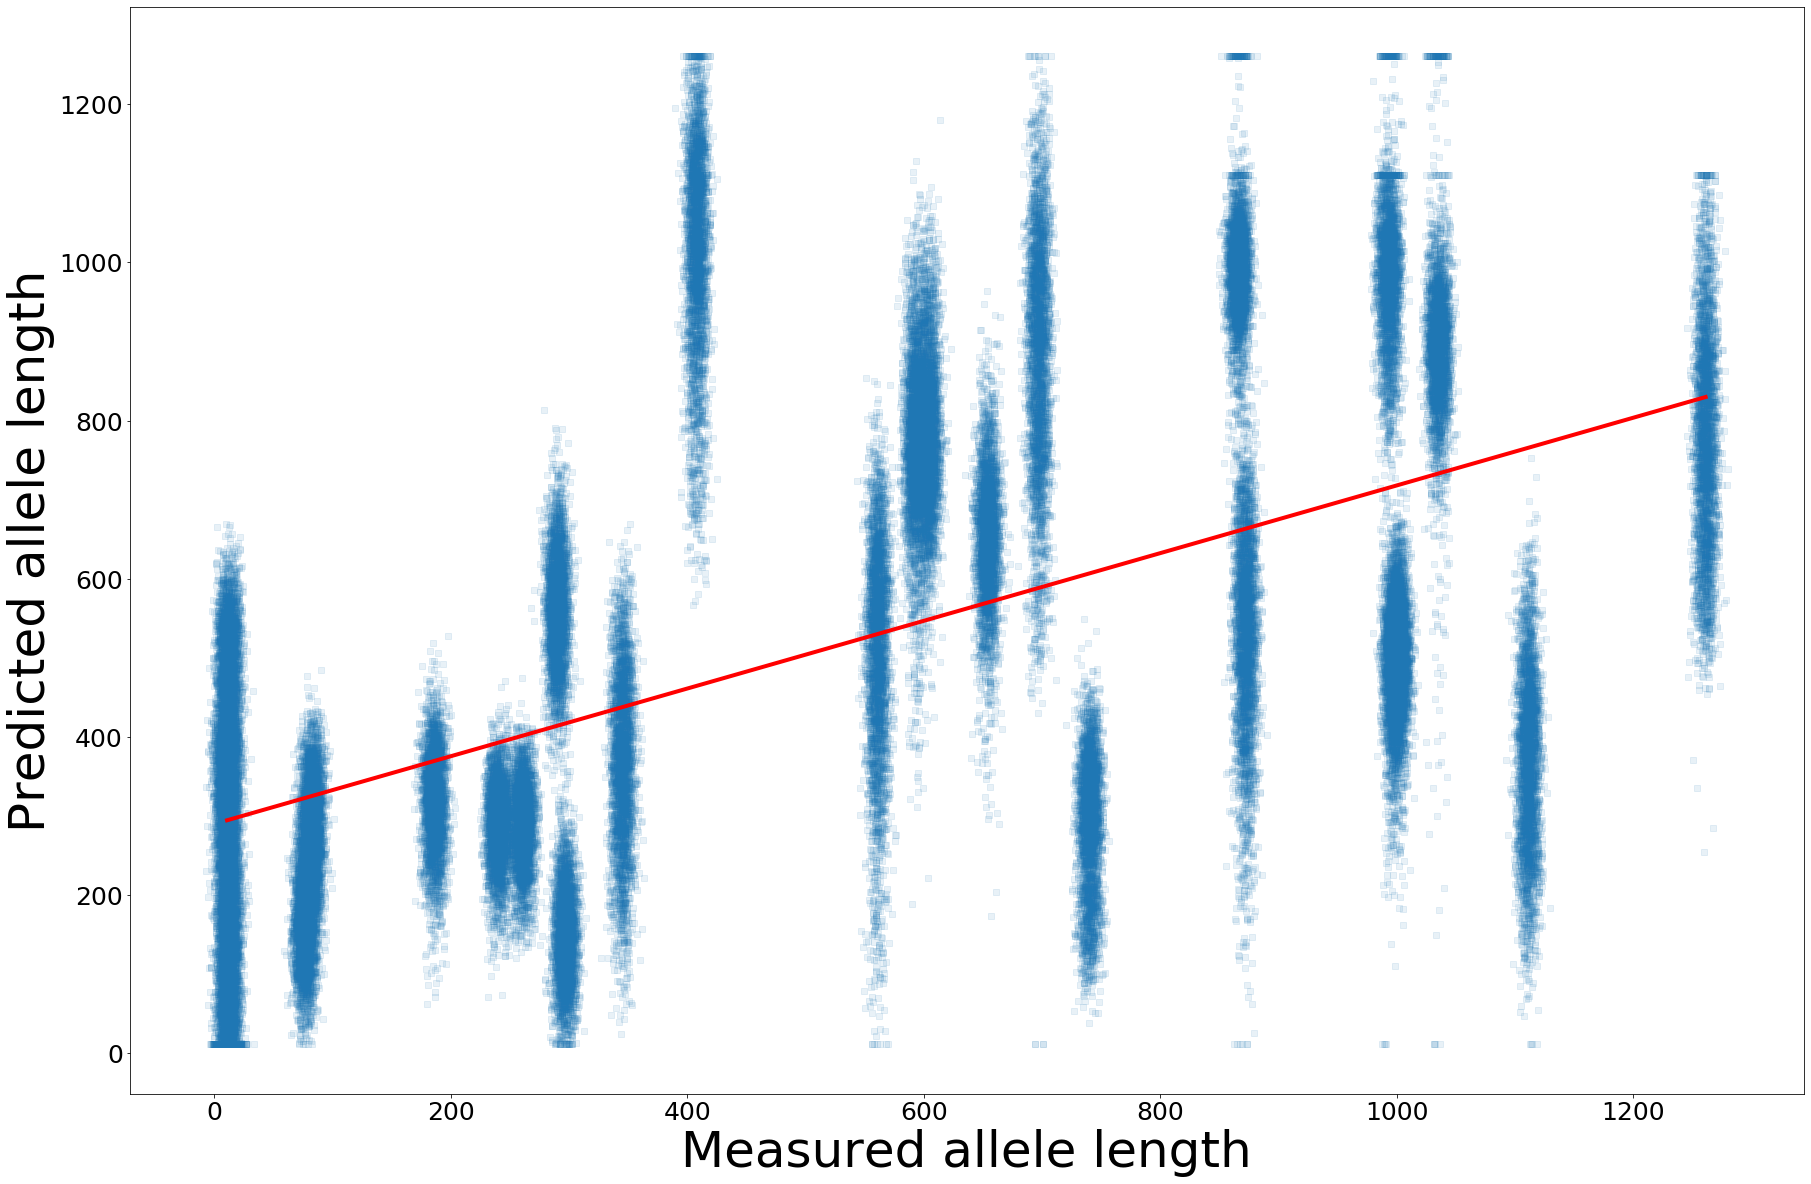

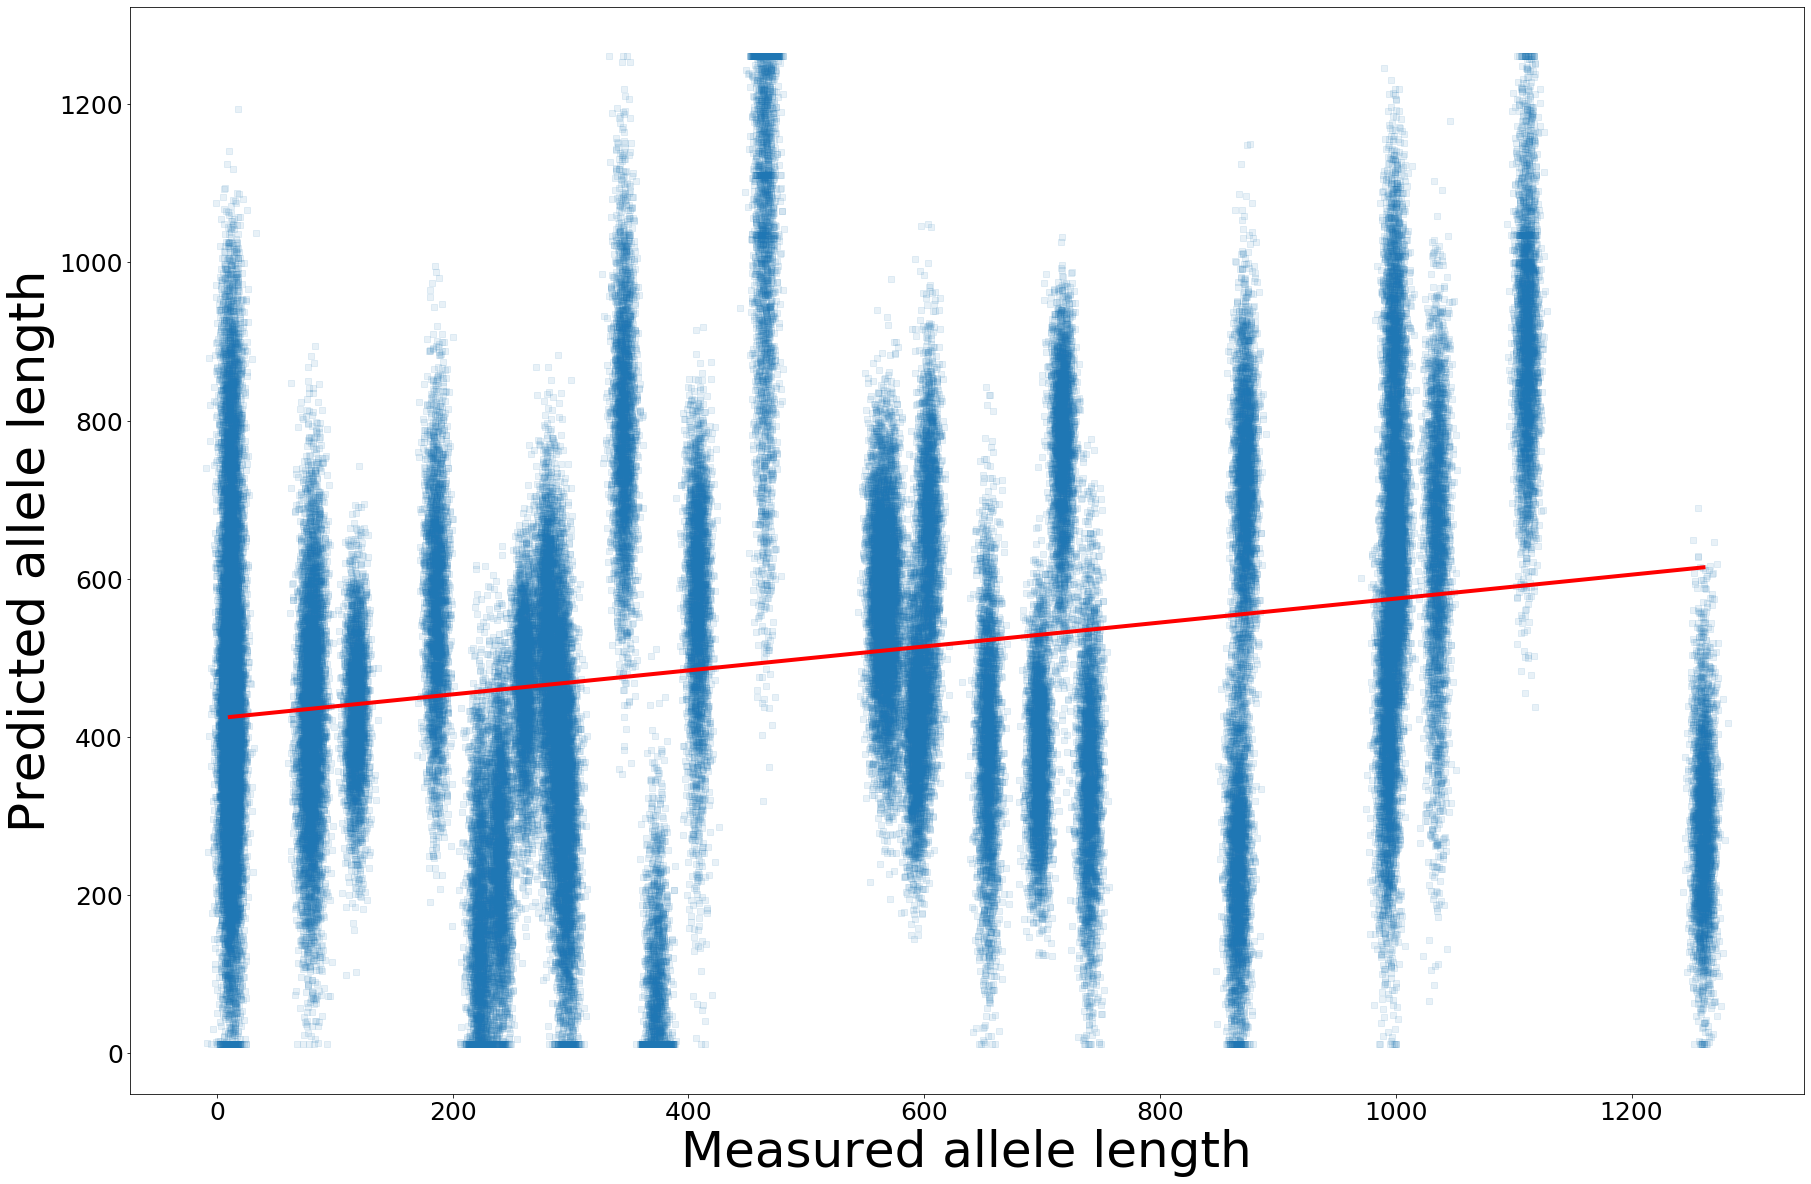

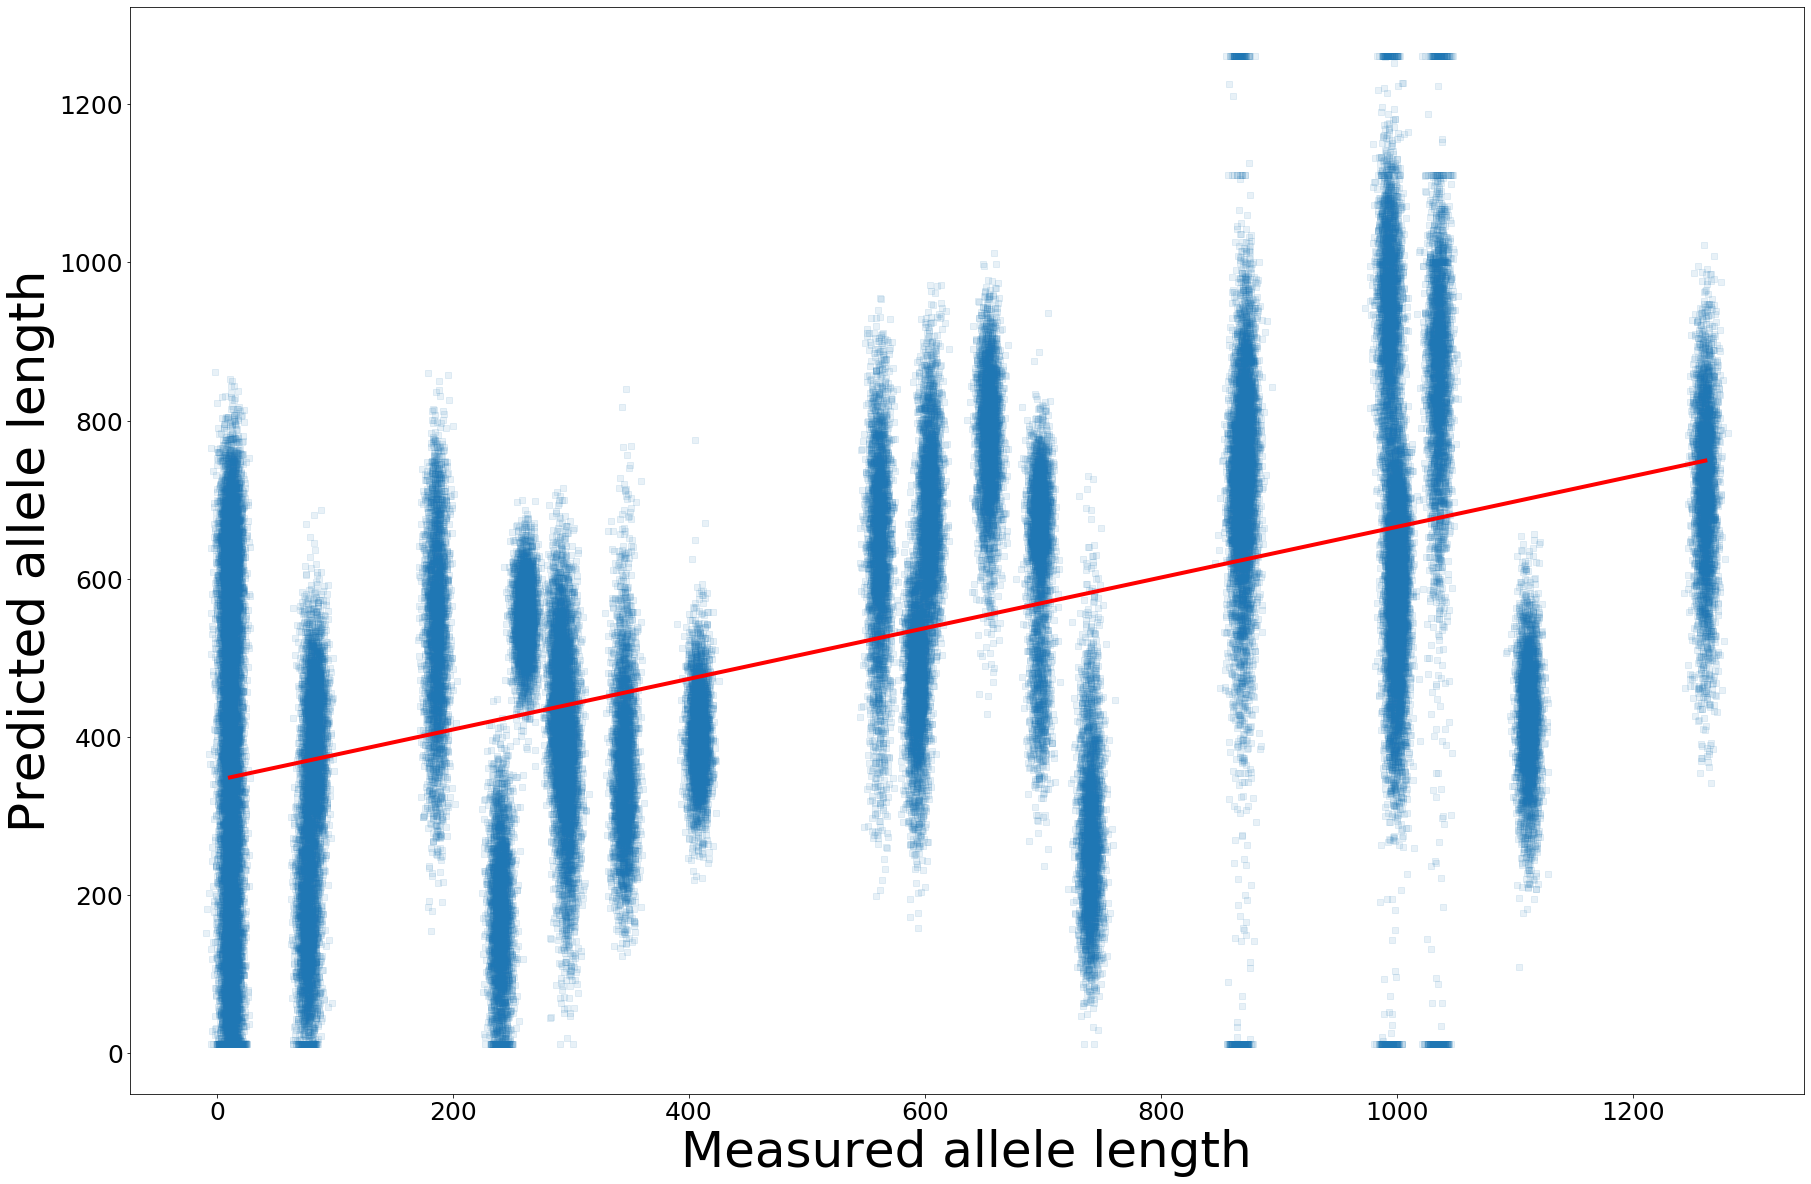

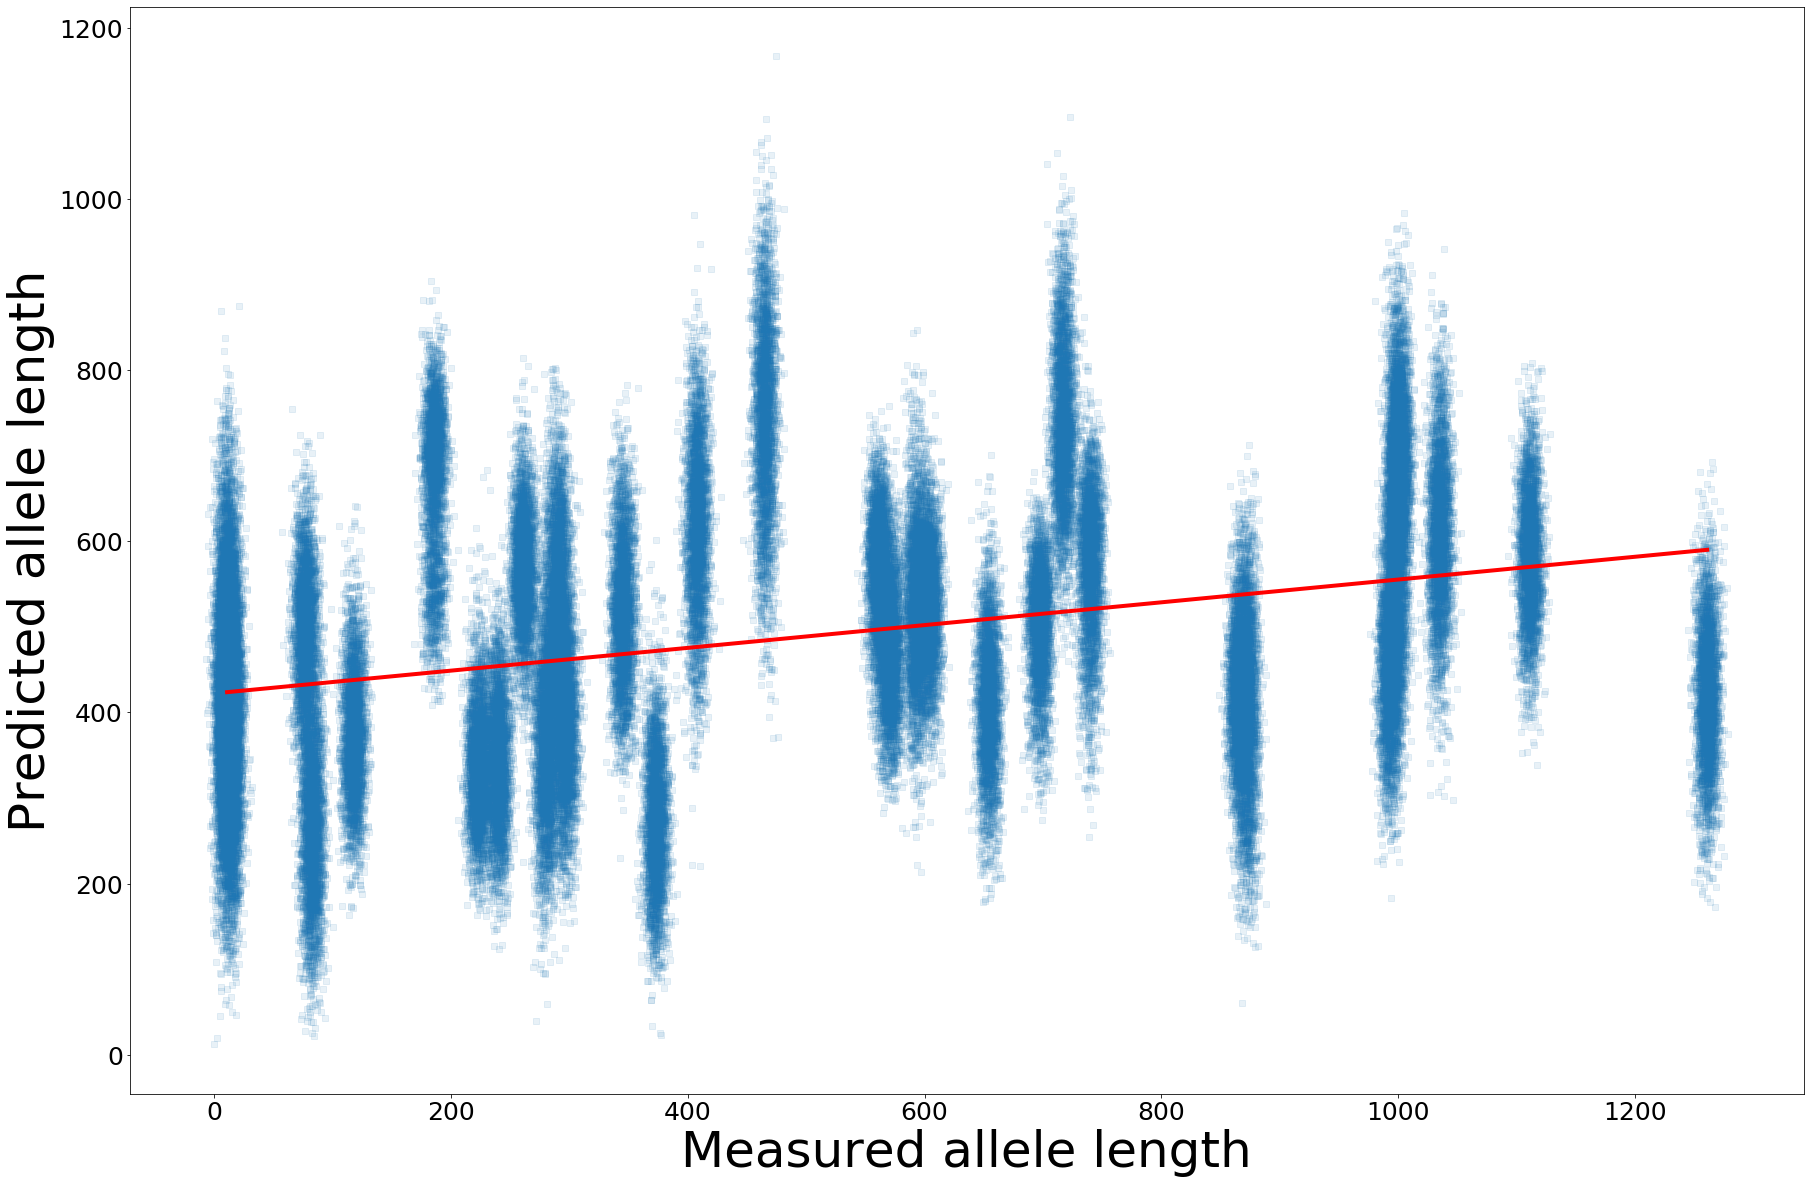

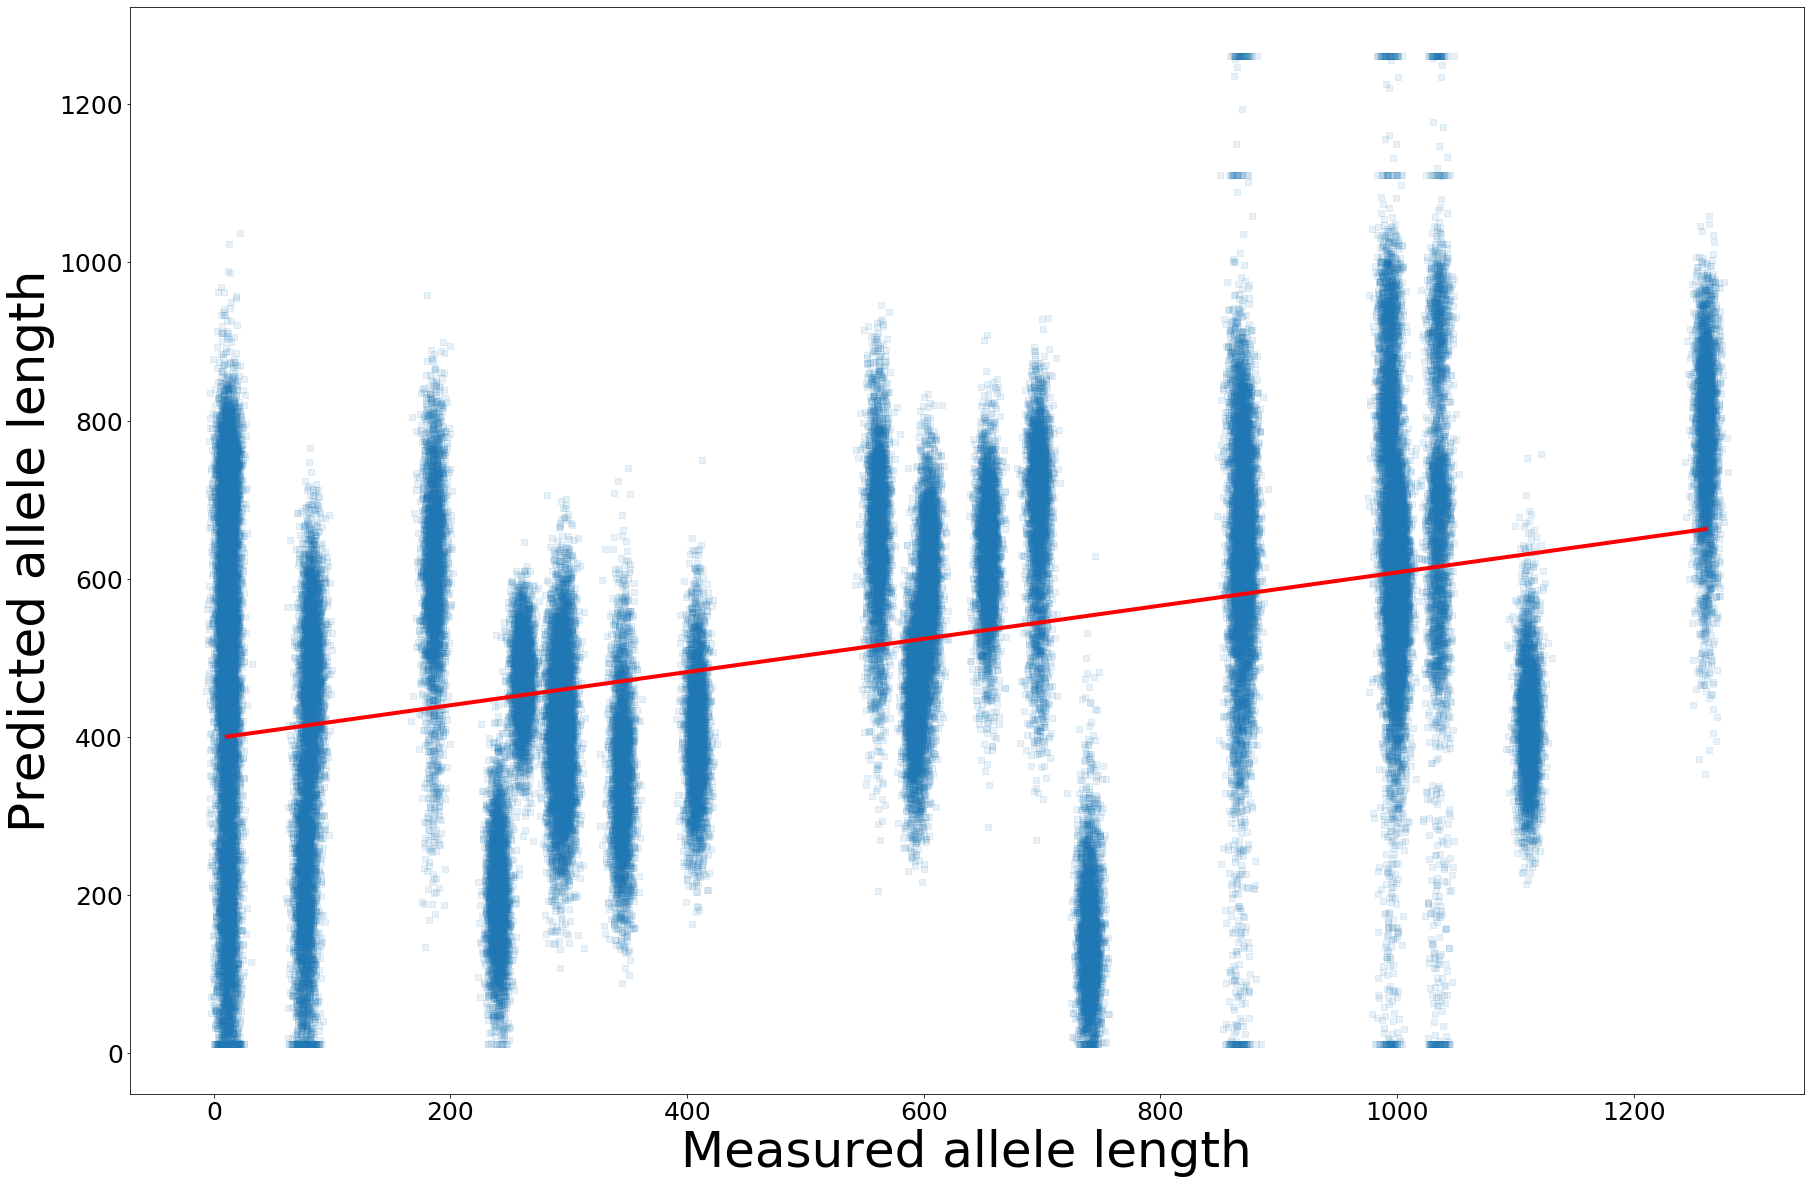

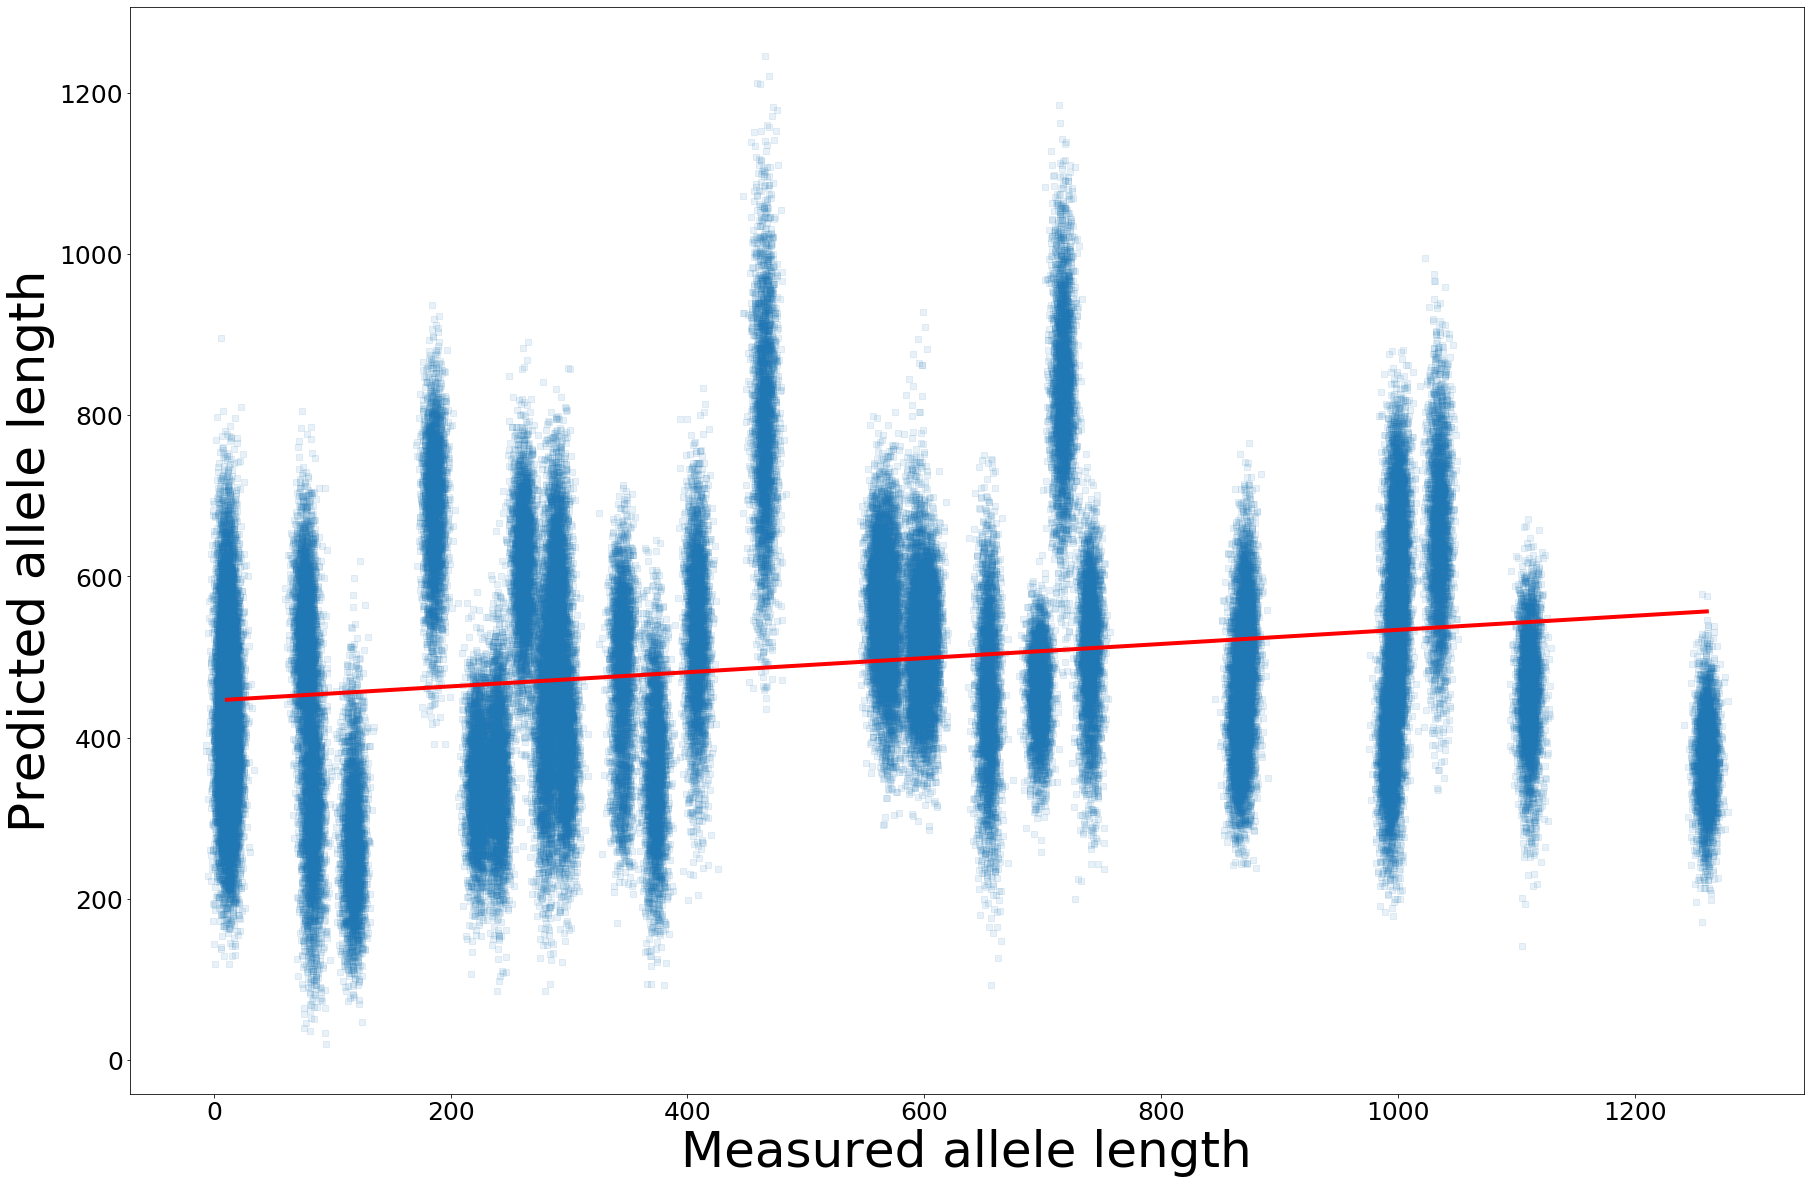

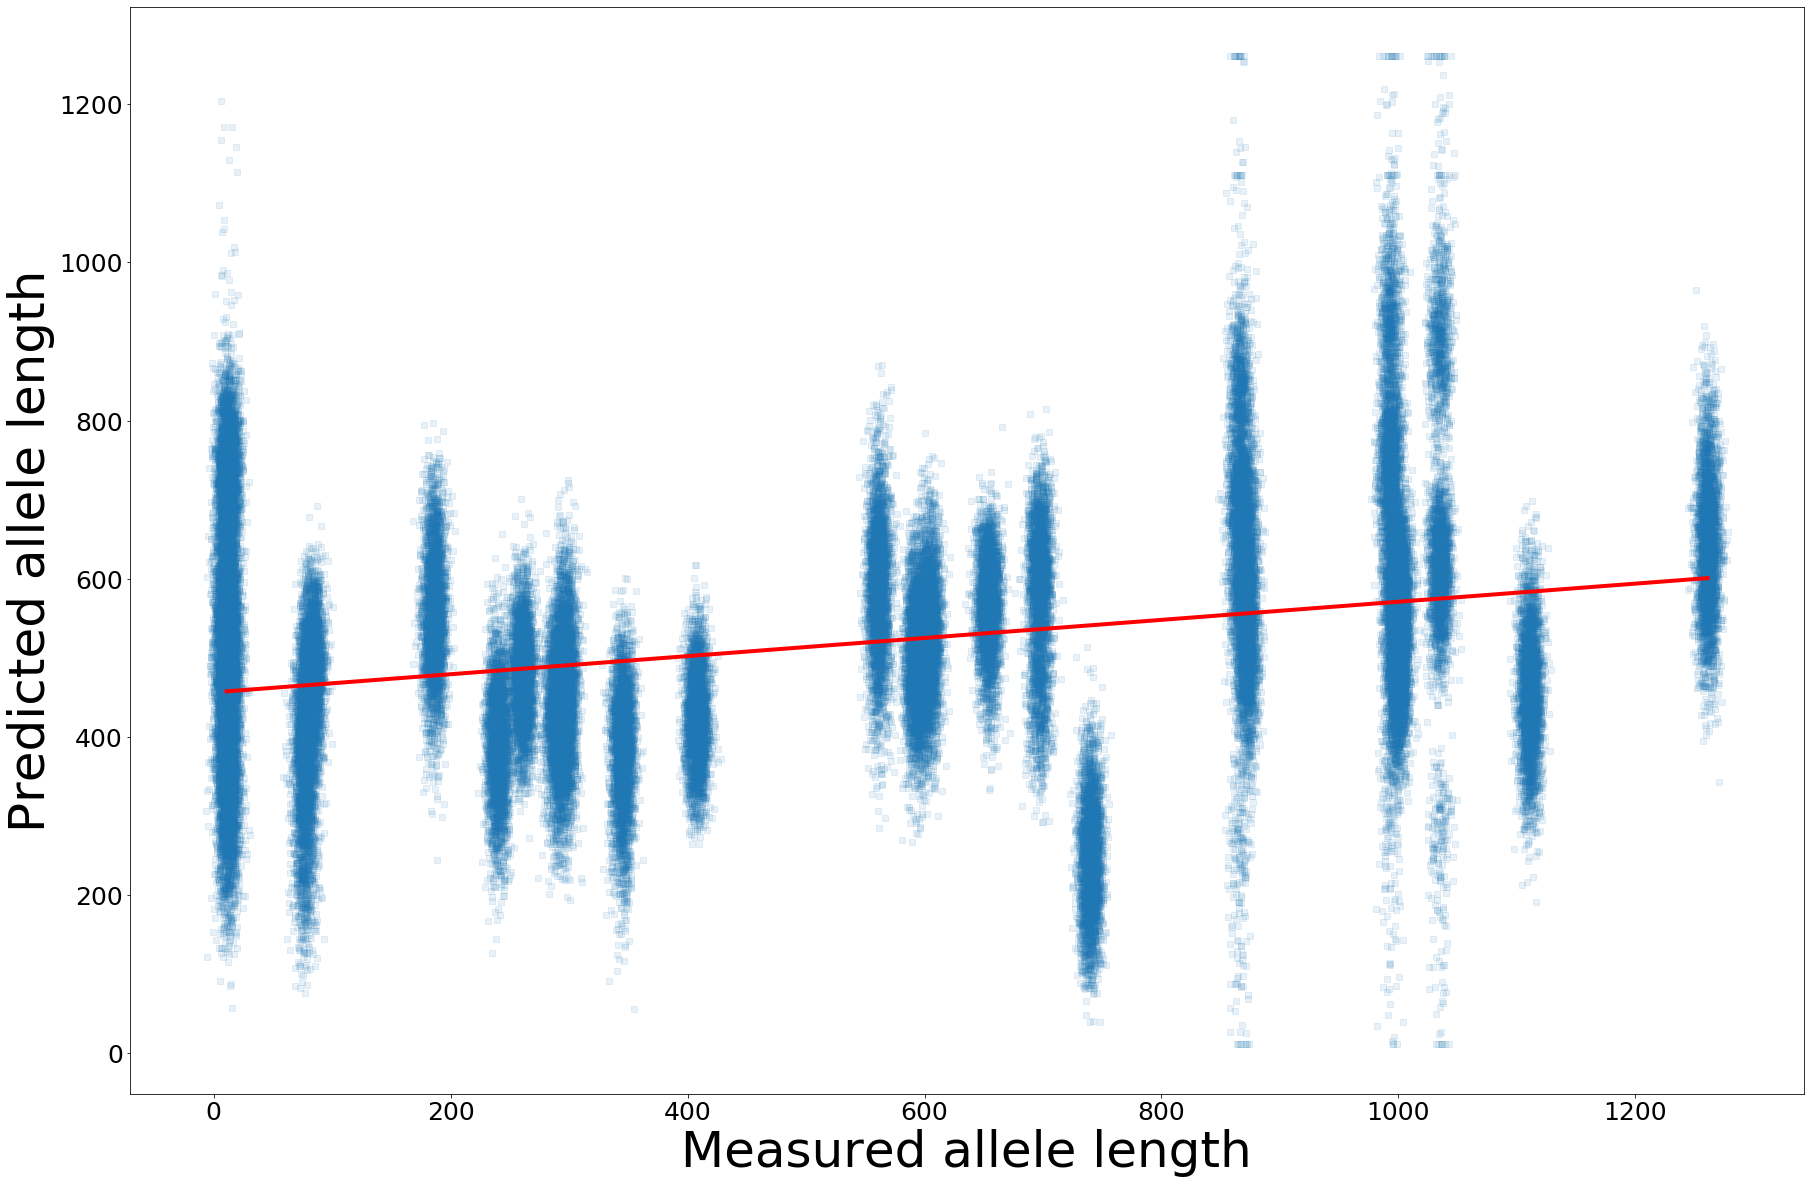

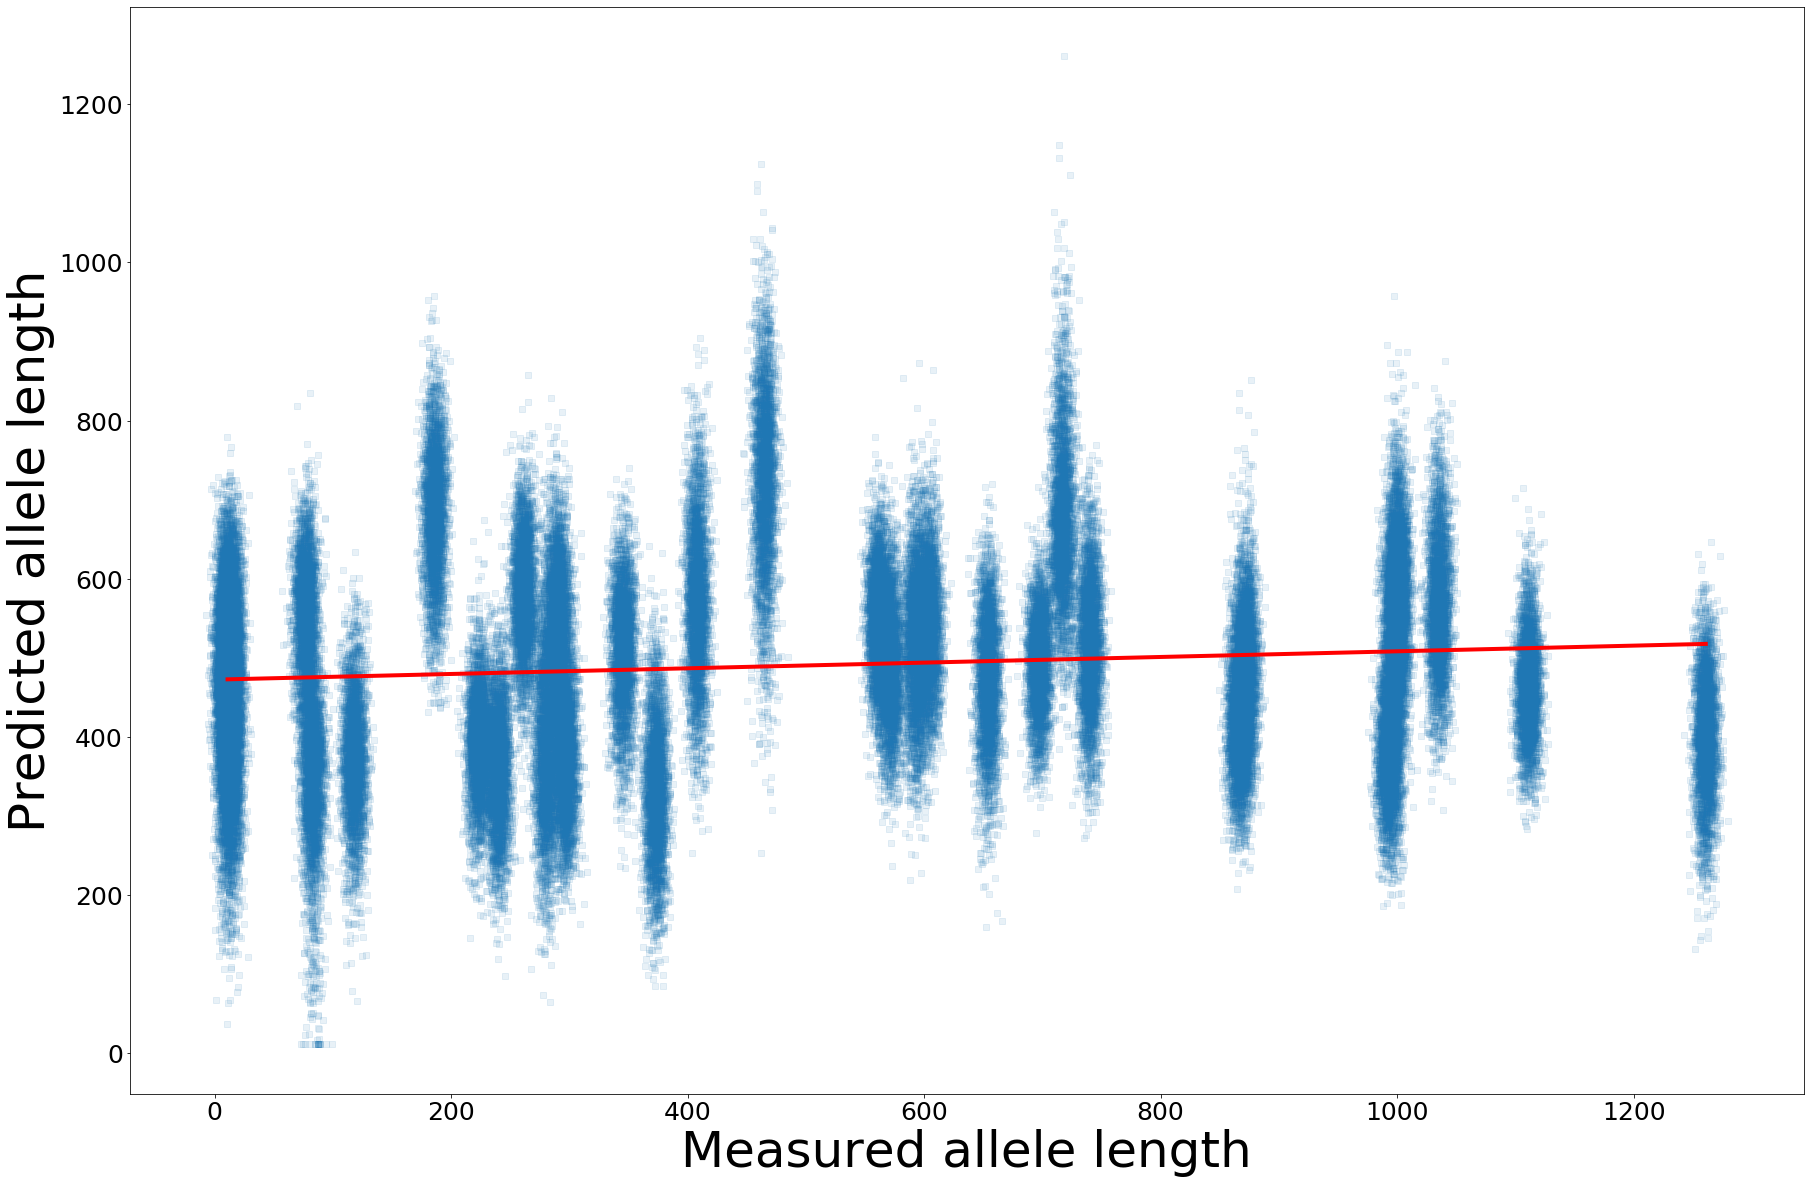

In [17]:
for path in PLSR_paths:
    present_results_path(path, title=False)

In [23]:
for path in PLSR_paths:
    present_results_r2(path)

AttributeError: module 'sklearn.metrics' has no attribute 'mean_square_error'

# Other models

In [ ]:
# LinearRegression
# RandomForestRegression
# LASSO
for path in extra_paths:
    present_results_path(path, title=False)

# Testing for convergence of the computed statistic

In [18]:
for i in range(9):
    present_results_r2("simulation_results_split5050/nakamori_muscle_1000{i}_500_simulation_step_PLSR".format(i=i))
outcomes_from_10k_simulations = [0.17461078196418756, 0.1728736379157501, 0.1795407405544879, 0.17498117164902297, 0.17435146220821612, 0.1817742038445883, 0.1759813371893236, 0.1760708561114535, 0.1781200836943841]
avg_outcome = sum(outcomes_from_10k_simulations)/len(outcomes_from_10k_simulations)
discrepancies = []
for outcome in outcomes_from_10k_simulations:
    discrepancies.append((avg_outcome - outcome)/avg_outcome*100)
sorted(discrepancies)

0.17461078196418756
0.1728736379157501
0.1795407405544879
0.17498117164902297
0.17435146220821612
0.1817742038445883
0.1759813371893236
0.1760708561114535
0.1781200836943841


[-3.000908592652183,
 -1.7353343619689265,
 -0.9303304379017678,
 0.2308480928837935,
 0.28157327896959794,
 0.8483091370570505,
 1.0581875095901017,
 1.2051289892728774,
 2.0425263847494874]

In [64]:
avg_outcome

0.17647825279237936

# That's how much better 70/30 CV is vs 80/20

In [67]:
0.176/0.285

0.6175438596491228